# Temperature Profile Timeseries
This looks at a single coordinate, evaluating whether the evolution of the temperature profile in the week before the hot day. The idea is to compare to the results of Funing Li 2025 paper.

In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.thesis.adiabat_theory import get_z_ft_approx
from isca_tools.utils import area_weighting
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load in data
First load in the temperature profile. Then load in the surface pressure, and compute REFHT variables.

Also, compute the LCL, and lapse rates below and above this.

In [3]:
exp_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/raw_subset'
exp_names = ['pre_industrial', 'co2_2x']
n_exp = len(exp_names)
ds_all = [xr.load_dataset(os.path.join(exp_dir, exp_names[i] + '.nd2')) for i in range(n_exp)]
ds_lnd = [xr.load_dataset(os.path.join(exp_dir, exp_names[i] + '_lnd.nd2')) for i in range(n_exp)]

def parse_co2_multiplier(name: str) -> float:
    if name == 'pre_industrial':
        return 1.0
    if name.startswith('co2_') and name.endswith('x'):
        s = name[len('co2_'):-1].replace('_', '.')
        try:
            return float(s)
        except ValueError:
            pass
    raise ValueError(f"Unrecognized experiment name format for CO2 multiplier: {name}")


co2_vals = [parse_co2_multiplier(n) for n in exp_names]
ds_all = xr.concat(ds_all, dim=xr.Variable("co2", co2_vals))
ds_lnd = xr.concat(ds_lnd, dim=xr.Variable("co2", co2_vals))
ds_all = ds_all.rename_vars({'TREFHT': 'TS', 'QREFHT': 'QS'})           # rename 2m variables as surface
ds_all['SOILLIQ'] = ds_lnd.SOILLIQ
del ds_lnd
ds_all = ds_all.load()
n_loc = ds_all.sizes['loc']
loc_names = ds_all['loc'].values.tolist()

In [4]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['PHIS']]
z2m = []
for i in range(n_loc):
    z2m.append(float(invariant_data.PHIS.sel(lat=ds_all.isel(loc=i).lat, lon=ds_all.isel(loc=i).lon, method='nearest')/g + 2))
ds_all['ZS'] = xr.DataArray(z2m, dims=["loc"], name="z2m")

def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0).load(), ds.hybm.isel(time=0).load(), float(ds.P0.isel(time=0))
ds_all['hyam'], ds_all['hybm'], p0 = get_lev_info()

In [5]:
refht_level_index = -3
# refht_level_index = None
ds_all['p'] = isca_tools.cesm.get_pressure(ds_all.PS, p0, ds_all['hyam'], ds_all['hybm'])
if refht_level_index is not None:
    ds_all['TREFHT'] = ds_all.T.isel(lev=refht_level_index)
    ds_all['QREFHT'] = ds_all.Q.isel(lev=refht_level_index)
    ds_all['PREFHT'] = ds_all.p.isel(lev=refht_level_index)
    ds_all['ZREFHT'] = ds_all.Z3.isel(lev=refht_level_index)
else:
    ds_all['TREFHT'] = ds_all.TS
    ds_all['QREFHT'] = ds_all.QS
    ds_all['PREFHT'] = ds_all.PS
    ds_all['ZREFHT'] = ds_all.ZS
ds_all['rh_REFHT'] = ds_all['QREFHT'] / sphum_sat(ds_all['TREFHT'], ds_all['PREFHT'])

In [6]:
# Get info at 500hPa
pressure_ft = 500 * 100
ds_all['T500'] = interp_hybrid_to_pressure(ds_all.T, ds_all.PS, ds_all.hyam, ds_all.hybm, p0, np.asarray([pressure_ft]))
ds_all['Z500'] = interp_hybrid_to_pressure(ds_all.Z3, ds_all.PS, ds_all.hyam, ds_all.hybm, p0, np.asarray([pressure_ft]))
ds_all['mse_REFHT'] = moist_static_energy(ds_all.TREFHT, ds_all.QREFHT, ds_all.ZREFHT)
ds_all['mse_sat_500'] = moist_static_energy(ds_all.T500, sphum_sat(ds_all.T500, pressure_ft), ds_all.Z500)
ds_all = ds_all.load()

In [7]:
# Get hottest days with 7 days either side
# In lag, positive means occured day before
shifts = np.arange(8)[::-1]     # +1 means to get the day before; -1 means to get the day after
shifts = np.concatenate((shifts, np.arange(-7, 0)[::-1]))
ds_lagged = xr.concat(
    [ds_all.shift(time=s) for s in shifts],
    dim="lag"

)
ds_lagged = ds_lagged.assign_coords(lag=shifts)

# Get hottest days
quant = 95
quant_mask = get_quant_ind(ds_all.TREFHT, quant, 0, np.inf,
                           return_mask=True, av_dim='time')
ds_hot = []
for i in range(n_exp):
    ds_use = [ds_lagged.isel(loc=j, co2=i).where(quant_mask.isel(loc=j, co2=i), drop=True) for j in range(n_loc)]
    n_sample = ds_use[0].time.size
    for j in range(n_loc):
        ds_use[j] = ds_use[j].rename({'time': 'sample'}).assign_coords({'sample': np.arange(n_sample)})
    ds_hot.append(xr.concat(ds_use, dim='loc'))
ds_hot = xr.concat(ds_hot, dim='co2')
ds_hot = ds_hot.load()
del ds_lagged

In [8]:
def apply_func_vec(func, n_lev_args, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    # n_lev_args is the number of arguments (ignoring pressure) with a level dimension. The non level args must be given first
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * (len(args)-n_lev_args) + [['lev']] * (n_lev_args + 1),
                          output_core_dims=[['lev']], vectorize=True, dask='parallelized', output_dtypes=[float])


def conv_neutral_profile(temp_lcl, p_lcl, p):
    if np.isnan(temp_lcl):
        return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

def mse_env_profile(p_lcl, q_refht, temp_env, z_env, p):
    # MSE profile maintains surface specific humifity up to LCL then is saturated
    mse_profile = moist_static_energy(temp_env, sphum_sat(temp_env, p), z_env)
    # Replace values below the LCL with MSE using q_refht
    mask = p >= p_lcl
    mse_profile = xr.where(mask, moist_static_energy(temp_env, q_refht, z_env), mse_profile)
    return mse_profile

def moist_above_lcl_profile(temp_at_lcl, p_at_lcl, temp_refht, p_refht, p):
    if np.isnan(temp_at_lcl):
        return temp_at_lcl * p          # if not land return numpy array of nans of same length as p
    # Follows moist adiabat above p_lcl then follows constant lapse to surface
    temp_profile = moist_profile(float(temp_at_lcl), float(p_at_lcl), p)
    lapse_below_lcl = float(get_bulk_lapse_rate(temp_refht, temp_at_lcl, p_refht, p_at_lcl)) * 1000
    temp_profile[p>=p_at_lcl] = reconstruct_temp(float(temp_at_lcl), p[p>=p_at_lcl], p[p>=p_at_lcl], p_at_lcl,
                                              lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

def const_lapse_lcl_profile(temp_refht, p_refht, temp_at_lcl, p_at_lcl, lapse_below_lcl, lapse_above_lcl, p):
    temp_profile = reconstruct_temp(temp_at_lcl, p, p, p_at_lcl, lapse_above_lcl/1000, lapse_above_lcl/1000)
    temp_profile[p>=p_at_lcl] = reconstruct_temp(temp_refht, p[p>=p_at_lcl], p[p>=p_at_lcl], p_refht, lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

# # Compute constant lapse rate profile
# ds_use = interp_var_at_pressure(ds.T, ds.p_lcl, ds.PS,
#                                 ds.hyam, ds.hybm, p0)
# ds['T_at_lcl'] = ds_use.T
# ds['p_at_lcl'] = ds_use.plev.transpose()
# ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_at_lcl, ds.PREFHT,
#                                             ds.p_at_lcl) * 1000
# ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl, ds.T500.isel(plev=0), ds.p_at_lcl, float(ds.plev)) * 1000
# ds['T_const_lapse'] = apply_func_vec(const_lapse_lcl_profile, ds.p, ds.TREFHT, ds.PREFHT, ds.T_at_lcl,
#                                      ds.p_at_lcl, ds.lapse_below_lcl, ds.lapse_above_lcl)
# ds_hot = ds_hot.load()

In [9]:
def get_lnb_guess(temp, pressure, pressure_ft):
    # Get level half way between pressure_ft and tropopause
    # condition: temp at lev > temp at next lev (difference along lev)
    inversion_condition = temp > temp.shift(lev=-1)
    # we only compare up to the second-to-last level
    inversion_condition = inversion_condition.isel(lev=slice(None, -1))
    # Pressures at an inversion
    pressure_valid = pressure.isel(lev=slice(None, -1)).where(inversion_condition)
    pressure_valid = pressure_valid.where(pressure_valid<pressure_ft)       # must be below ft level
    pressure_tropopause = pressure_valid.max(dim='lev')
    pressure_lnb_approx = (pressure_tropopause + pressure_ft) / 2
    return np.abs(pressure_lnb_approx - pressure).where(pressure<pressure_ft).argmin(dim='lev')

ds_hot['lev_min'] = get_lnb_guess(ds_hot.T.mean(dim='sample'), ds_hot.p.mean(dim='sample'), pressure_ft)

In [10]:
# Only interested between REFHT and LNB, so only use certain levels
if ds_hot.lev.min()<10:          # If have not already done lev slicing, do it here
    # if refht_level_index is None or refht_level_index == -1:
    #     lev_use_max = ds_hot.lev.size
    # else:
    #     lev_use_max = refht_level_index + 1           # don't want to go below our REFHT
    lev_use_max = ds_hot.lev.size   # include up to surface
    # Only go up to LNB at location with LNB furthest from surface
    ds_hot = ds_hot.isel(lev=slice(int(ds_hot['lev_min'].min()), lev_use_max))
    ds_hot['lev_min'] = ds_hot['lev_min'] - int(ds_hot['lev_min'].min())        # record LNB for each loc relative to new lev
    # Remove levels above LNB for all variables except pressure - CAUSES ISSUES IF Temperature for interpolating
    # for var in ds_hot.data_vars:
    #     if var in ['p', 'T']:
    #         continue        # need to keep pressure to do vectorized calculations
    #     if 'lev' in ds_hot[var].dims:
    #         ds_hot[var] = ds_hot[var].where(ds_hot.lev>=ds_hot.lev.isel(lev=ds_hot.lev_min))
    # ds_hot = ds_hot.isel(lev=slice(int(ds_hot.lev_min.min()), ds_hot.lev.size+10000))
    # ds_hot['p'] = ds_hot.p.where(ds_hot.lev>=ds_hot.lev[ds_hot.lev_min], drop=True)
    # ds_hot['lev_min'] = ds_hot['lev_min'].isel(lev=-1, drop=True).astype(int)       # make ds_hot same as it was initially

In [77]:
ds_hot['p_lcl'], ds_hot['T_lcl'] = lcl_metpy(ds_hot.TREFHT.fillna(0), ds_hot.QREFHT.fillna(0), ds_hot.PREFHT.fillna(0))
ds_hot['T_sqe'] = apply_func_vec(conv_neutral_profile, 0, ds_hot.p, ds_hot.T_lcl, ds_hot.p_lcl)
ds_hot['T_sqe'] = ds_hot['T_sqe'].where(ds_hot.lev >= ds_hot.lev.isel(lev=ds_hot.lev_min))          # only keep profile up to LNB
ds_hot['T_sqe_error'] = np.abs(ds_hot.T - ds_hot['T_sqe']).mean(dim='lev').fillna(np.inf)
ds_hot['mse_env'] = apply_func_vec(mse_env_profile, 2, ds_hot.p, ds_hot.p_lcl, ds_hot.QREFHT, ds_hot.T, ds_hot.Z3)
ds_hot = ds_hot.load()

In [78]:
ds_hot['QREFHT5'] = ds_hot['QREFHT'] - (ds_hot.mse_REFHT - ds_hot.mse_sat_500).isel(plev=0) * 1000 / L_v
ds_hot['p_lcl5'], ds_hot['T_lcl5'] = lcl_metpy(ds_hot.TREFHT.fillna(0), ds_hot.QREFHT5.fillna(0), ds_hot.PREFHT.fillna(0))
ds_hot['T_sqe5'] = apply_func_vec(conv_neutral_profile, 0, ds_hot.p, ds_hot.T_lcl5, ds_hot.p_lcl5)
ds_hot['T_sqe5_error'] = np.abs(ds_hot.T - ds_hot['T_sqe5']).mean(dim='lev').fillna(np.inf)
ds_hot['rh_REFHT5'] = ds_hot['QREFHT5'] / sphum_sat(ds_hot['TREFHT'], ds_hot['PREFHT'])
ds_hot['mse_REFHT5'] = moist_static_energy(ds_hot.TREFHT, ds_hot.QREFHT5, ds_hot.ZREFHT)
ds_hot['mse_env5'] = apply_func_vec(mse_env_profile, 2, ds_hot.p, ds_hot.p_lcl, ds_hot.QREFHT5, ds_hot.T, ds_hot.Z3)
ds_hot = ds_hot.load()

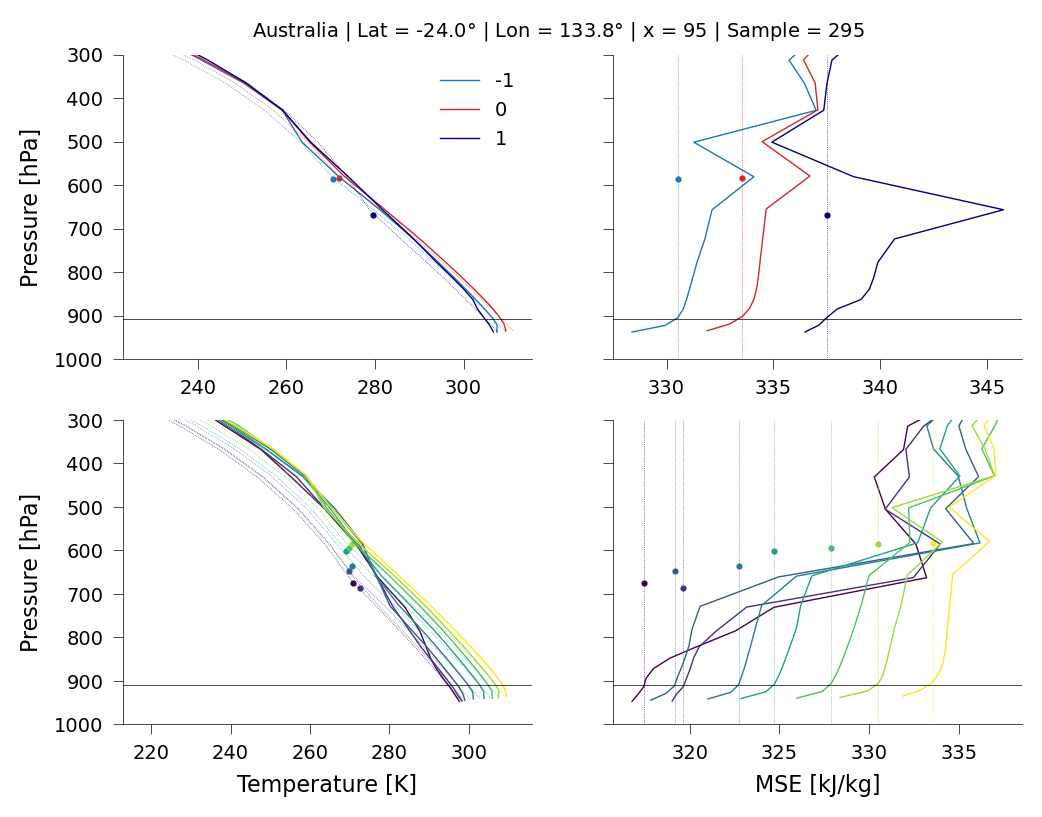

In [130]:
loc_plot = 'australia'
# sample_ind = 90 # spain good one
sample_ind = int(ds_hot.sel(lag=0, loc=loc_plot).isel(co2=0).TREFHT.argmax())           # hottest day
# sqe_use = '5'
sqe_use = ''
ds_use = ds_hot.isel(co2=0, sample=sample_ind).sel(loc=loc_plot).sel(lag=[1, 0, -1])
fig, ax = plt.subplots(2, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 5.8)
color_use = ['C0', 'C3', 'navy']
for i in range(ds_use.lag.size):
    ax[0, 0].plot(ds_use.T.isel(lag=i), ds_use.p.isel(lag=i)/100, color=color_use[i], label=f'{-ds_use.lag[i]:.0f}')
    ax[0, 0].plot(ds_use[f'T_sqe{sqe_use}'].isel(lag=i), ds_use.p.isel(lag=i)/100, color=color_use[i], linestyle=':', lw=ax_linewidth)
    ax[0, 0].scatter(ds_use[f'T_lcl{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')
    ax[0, 1].plot(ds_use[f'mse_env{sqe_use}'].isel(lag=i), ds_use.p.isel(lag=i)/100, color=color_use[i])
    ax[0, 1].axvline(ds_use[f'mse_REFHT{sqe_use}'].isel(lag=i), color=color_use[i], lw=ax_linewidth, linestyle=':')
    ax[0, 1].scatter(ds_use[f'mse_REFHT{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')

ds_use = ds_hot.isel(co2=0, sample=sample_ind).sel(loc=loc_plot).sel(lag=np.arange(8)[::-1])
color_use = plt.cm.viridis(np.linspace(0, 1, ds_use.lag.size))
for i in range(ds_use.lag.size):
    ax[1, 0].plot(ds_use.T.isel(lag=i), ds_use.p.isel(lag=i)/100, color=color_use[i], label=f'{-ds_use.lag[i]:.0f}')
    ax[1, 0].plot(ds_use[f'T_sqe{sqe_use}'].isel(lag=i), ds_use.p.isel(lag=i)/100, color=color_use[i], linestyle=':', lw=ax_linewidth)
    ax[1, 0].scatter(ds_use[f'T_lcl{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')
    ax[1, 1].plot(ds_use[f'mse_env{sqe_use}'].isel(lag=i), ds_use.p.isel(lag=i)/100, color=color_use[i])
    ax[1, 1].axvline(ds_use[f'mse_REFHT{sqe_use}'].isel(lag=i), color=color_use[i], lw=ax_linewidth, linestyle=':')
    ax[1, 1].scatter(ds_use[f'mse_REFHT{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')

for ax_use in ax.flatten():
    ax_use.axhline(ds_use.p.isel(lev=refht_level_index).mean()/100, color='k', lw=ax_linewidth)

fig.suptitle(
    f'{loc_plot.capitalize()} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$ |'
    f' x = {quant} | Sample = {sample_ind}', y=0.92, fontsize=7)
ax[1, 0].set_xlabel('Temperature [K]')
ax[1, 1].set_xlabel('MSE [kJ/kg]')
ax[0, 0].set_ylabel('Pressure [hPa]')
ax[1, 0].set_ylabel('Pressure [hPa]')
# ax[1].set_xlabel('Temperature change [K]')
ax[0, 0].legend()
# ax[1, 0].legend()
ax[0, 0].invert_yaxis()
ax[0, 0].set_ylim(1000, 300)
# isca_tools.plot.update_linewidth(fig)
# ax[0].legend()
# ax[1].axvline(0, color='k', lw=ax_linewidth)
plt.show()

### Time series of days which are hottest in a 2 week period
Here we show that rh_REFHT5 seems to be small on the hottest day, but T500 does not seem to be large.

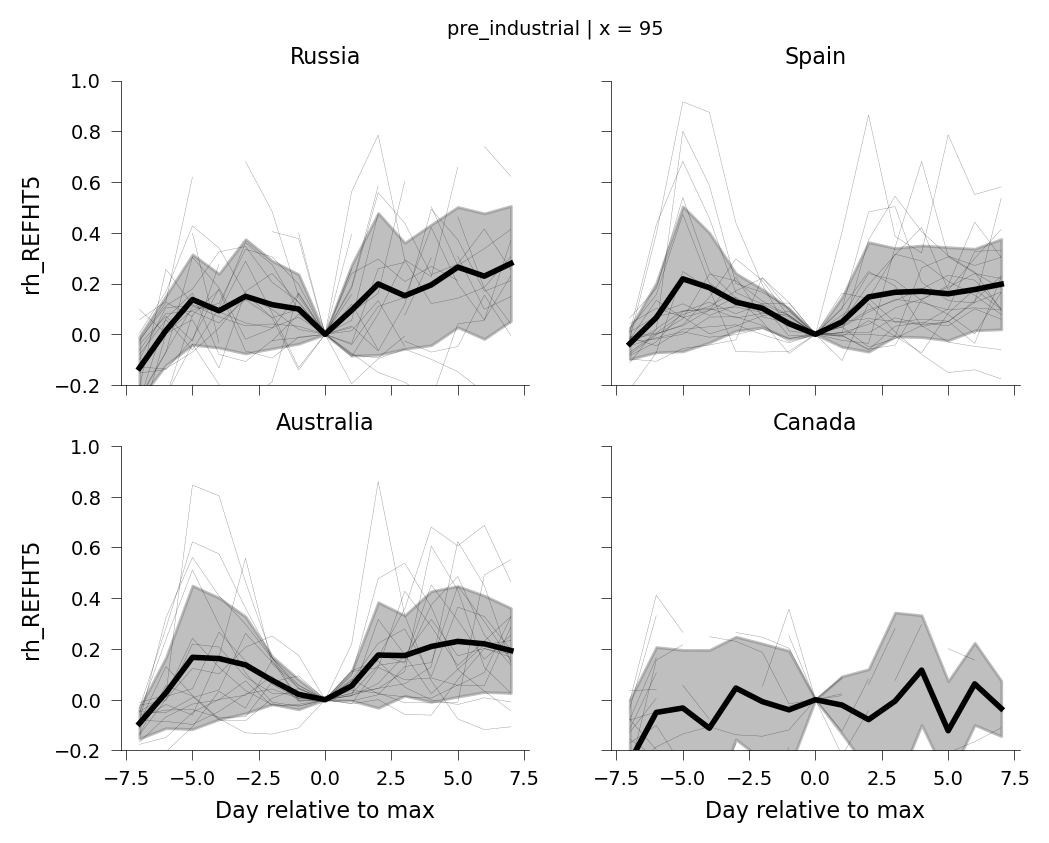

In [295]:
co2_ind = 0
keep = ds_hot.TREFHT.argmax(dim="lag") == 0
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 5.8)
ax = ax.flatten()
for i in range(ds_hot.dims['loc']):
    ax[i].set_title(loc_names[i].capitalize())
    var = (ds_hot.rh_REFHT5 - ds_hot.rh_REFHT5.sel(lag=0)).isel(loc=i, co2=co2_ind)
    var = var.where(keep.isel(loc=i, co2=co2_ind))
    var = var.where(ds_hot.rh_REFHT5.isel(loc=i, co2=co2_ind)<1.3)
    for j in range(var.sample.size):
        ax[i].plot(-ds_hot.lag, var.isel(sample=j), color='k', lw=ax_linewidth/2, alpha=0.5)
    ax[i].plot(-ds_hot.lag, var.mean(dim='sample'), color='k', lw=2)
    ax[i].fill_between(-ds_hot.lag, var.mean(dim='sample')-var.std(dim='sample'),
                       var.mean(dim='sample')+var.std(dim='sample'), color='grey', alpha=0.5)
ax[0].set_ylim(-0.2, 1)
ax[0].set_ylabel('rh_REFHT5')
ax[2].set_ylabel('rh_REFHT5')
ax[2].set_xlabel('Day relative to max')
ax[3].set_xlabel('Day relative to max')
fig.suptitle(f'{exp_names[co2_ind]} | x = {quant}', y=0.95, fontsize=7)
plt.show()
# var = ((ds_use.rh_REFHT5) - (ds_use.rh_REFHT5).sel(lag=0))
# var.mean(dim='sample').plot(color='k', lw=3)
# plt.fill_between(ds_use.lag, var.mean(dim='sample')-var.std(dim='sample'), var.mean(dim='sample')+var.std(dim='sample'), color='grey', alpha=0.5)
# plt.gca().set_xlim(-4, 4)

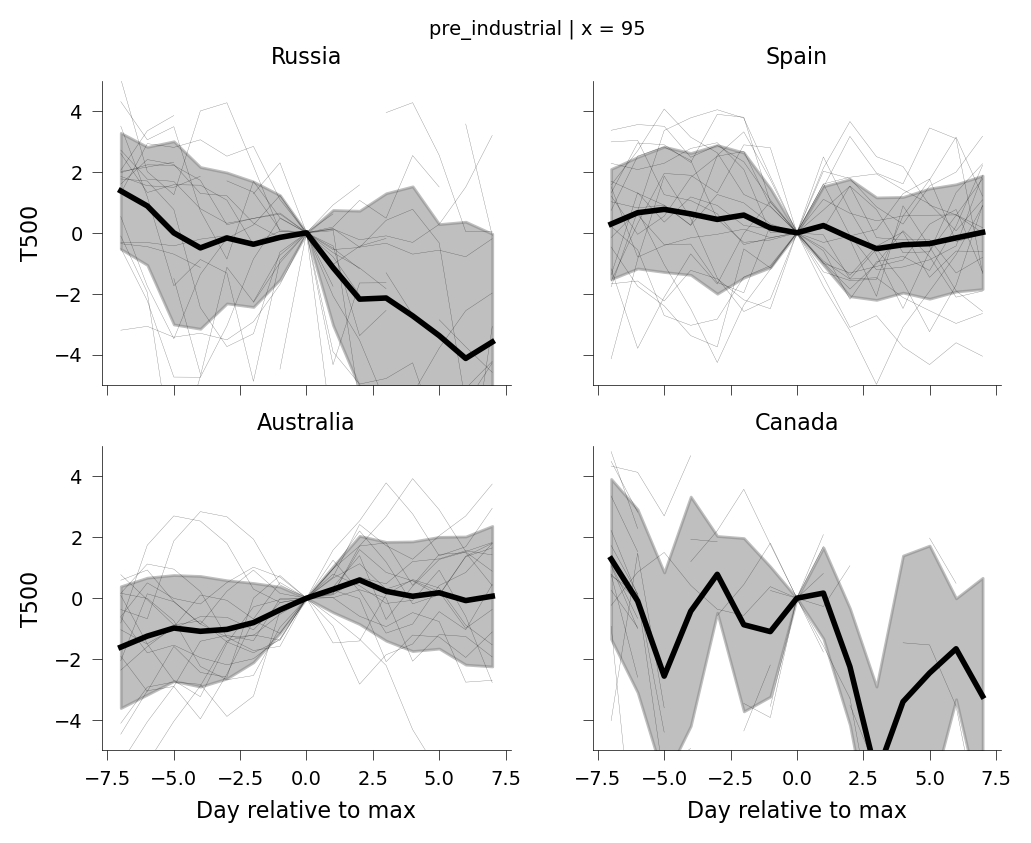

In [297]:
co2_ind = 0
keep = ds_hot.TREFHT.argmax(dim="lag") == 0
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 5.8)
ax = ax.flatten()
for i in range(ds_hot.dims['loc']):
    ax[i].set_title(loc_names[i].capitalize())
    var = (ds_hot.T500 - ds_hot.T500.sel(lag=0)).isel(loc=i, co2=co2_ind, plev=0)
    var = var.where(keep.isel(loc=i, co2=co2_ind))
    var = var.where(ds_hot.rh_REFHT5.isel(loc=i, co2=co2_ind)<1.3)
    for j in range(var.sample.size):
        ax[i].plot(-ds_hot.lag, var.isel(sample=j), color='k', lw=ax_linewidth/2, alpha=0.5)
    ax[i].plot(-ds_hot.lag, var.mean(dim='sample'), color='k', lw=2)
    ax[i].fill_between(-ds_hot.lag, var.mean(dim='sample')-var.std(dim='sample'),
                       var.mean(dim='sample')+var.std(dim='sample'), color='grey', alpha=0.5)
ax[0].set_ylabel('T500')
ax[2].set_ylabel('T500')
ax[2].set_xlabel('Day relative to max')
ax[3].set_xlabel('Day relative to max')
fig.suptitle(f'{exp_names[co2_ind]} | x = {quant}', y=0.95, fontsize=7)
ax[0].set_ylim(-5, 5)
plt.show()

### Level at which lapse rate falls below a threshold

In [233]:
loc_plot='canada'

In [234]:
# ds_use = ds_hot.isel(co2=0, sample=sample_ind).sel(loc=loc_plot).sel(lag=[1, 0, -1]).isel(lev=slice(0, refht_level_index+1))
ds_use = ds_hot.isel(co2=0).sel(loc=loc_plot, drop=True).isel(lev=slice(0, refht_level_index+1))
keep = ds_use.TREFHT.argmax(dim="lag") == 0    # only keep days which are hottest in the 2 week period
ds_use = ds_use.where(keep, drop=True).isel(plev=0, levsoi=0)

In [235]:
from scipy.optimize import brentq
hyam = ds_hot.hyam.isel(co2=0, loc=0, lag=0, sample=0, drop=True).isel(lev=slice(0, refht_level_index+1))
hybm = ds_hot.hybm.isel(co2=0, loc=0, lag=0, sample=0, drop=True).isel(lev=slice(0, refht_level_index+1))
def get_lapse_at_p(temp_refht, p_refht, p_surface, p2, temp_env, hyam=hyam,
                   hybm=hybm, p0=p0):
    temp2 = interp_var_at_pressure(temp_env, np.atleast_1d(p2), p_surface,
                                   hyam, hybm, p0, var_name='T').T
    # print(p2/p_refht)
    # print(get_bulk_lapse_rate(temp_refht, temp2, p_refht, p2).values * 1000)
    return get_bulk_lapse_rate(temp_refht, temp2, p_refht, p2) * 1000

def find_p2_for_lapse(temp_refht, p_refht, p_surface, temp_env, hyam=hyam,
                      hybm=hybm, p0=p0, target=7, pmin=300*100, plev_step=1000):
    """
    Solve for p2 where bulk lapse rate = target (default 7).
    """
    plevs = np.arange(round_any(float(pmin), plev_step, 'floor'),
                      round_any(float(p_refht), plev_step, 'floor')+plev_step/2, plev_step)

    lapse_vals = np.asarray([get_lapse_at_p(temp_refht, p_refht, p_surface, p2,
                                            temp_env, hyam, hybm, p0) for p2 in plevs])
    valid_ind = np.where(lapse_vals>target)[0]
    if len(valid_ind) > 0:
        return plevs[valid_ind[0]]
    else:
        return np.nan

def xr_find_p2_for_lapse(temp_refht, p_refht, p_surface, temp_env,
                         hyam=hyam, hybm=hybm, p0=p0, target=7):
    return xr.apply_ufunc(
        find_p2_for_lapse,
        temp_refht, p_refht, p_surface, temp_env,
        input_core_dims=[[], [], [], ["lev"]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        kwargs=dict(target=target, hyam=hyam, hybm=hybm, p0=p0),
    )
ds_use['lapse_lcl'] = xr_find_p2_for_lapse(ds_use.TREFHT, ds_use.PREFHT, ds_use.PS, ds_use.T, target=8, hyam=hyam,
                                           hybm=hybm)

(-4.0, 4.0)

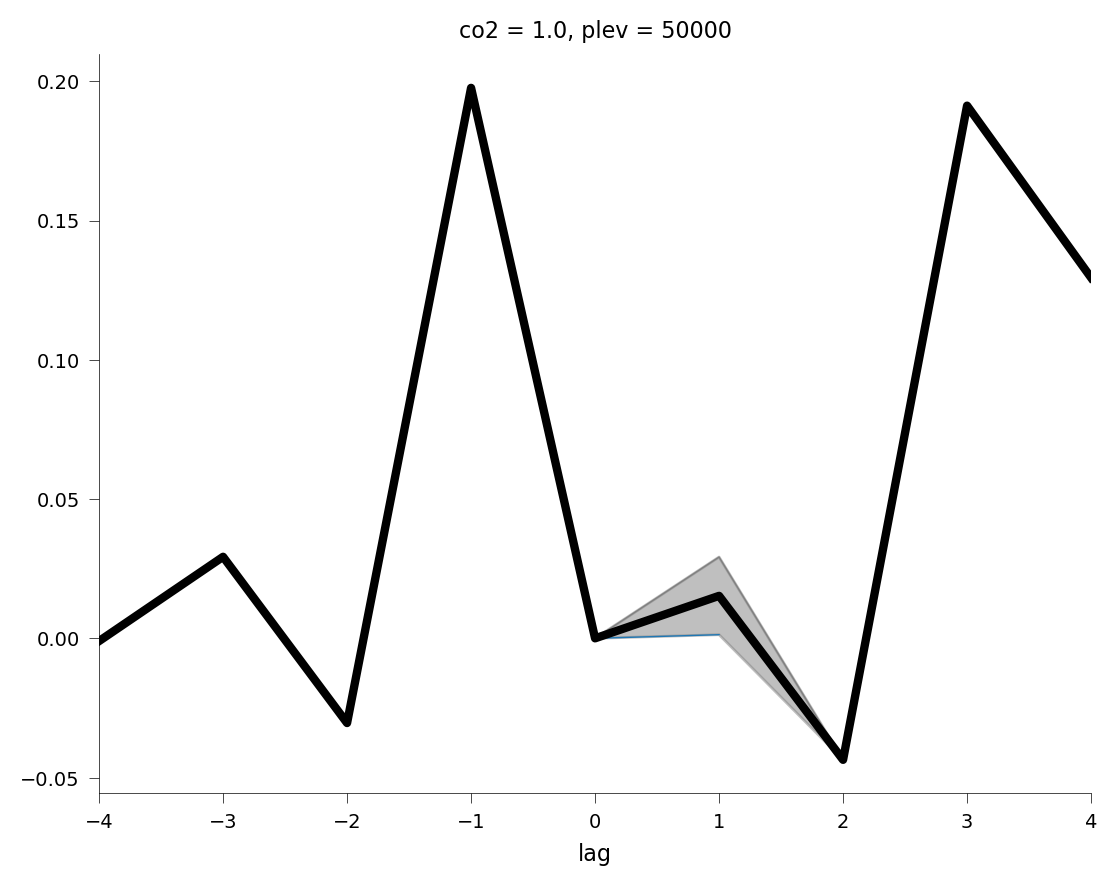

In [236]:
for i in range(ds_use.sample.size):
    var = (ds_use.lapse_lcl/ds_use.PREFHT).isel(sample=i)
    (var-var.sel(lag=0)).plot()
var = (ds_use.lapse_lcl/ds_use.PREFHT)
var = var-var.sel(lag=0)
var.mean(dim='sample').plot(color='k', lw=3)
plt.fill_between(ds_use.lag, var.mean(dim='sample')-var.std(dim='sample'), var.mean(dim='sample')+var.std(dim='sample'), color='grey', alpha=0.5)
plt.gca().set_xlim(-4, 4)

(-4.0, 4.0)

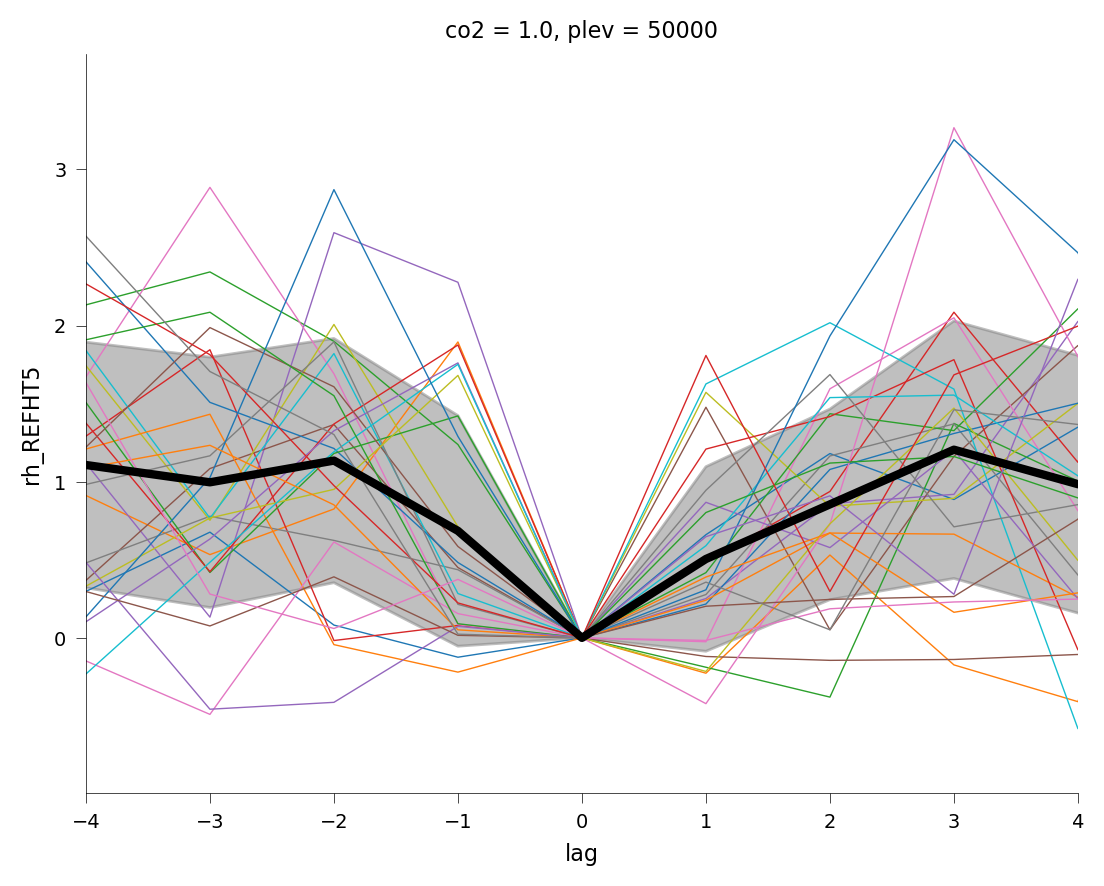

In [237]:
for i in range(ds_use.sample.size):
    # (ds_use.lapse_lcl/ds_use.PREFHT).isel(sample=i).plot()
    ((ds_use.rh_REFHT5).isel(sample=i) - (ds_use.rh_REFHT5).isel(sample=i).sel(lag=0)).plot()

var = ((ds_use.rh_REFHT5) - (ds_use.rh_REFHT5).sel(lag=0))
var.mean(dim='sample').plot(color='k', lw=3)
plt.fill_between(ds_use.lag, var.mean(dim='sample')-var.std(dim='sample'), var.mean(dim='sample')+var.std(dim='sample'), color='grey', alpha=0.5)
plt.gca().set_xlim(-4, 4)

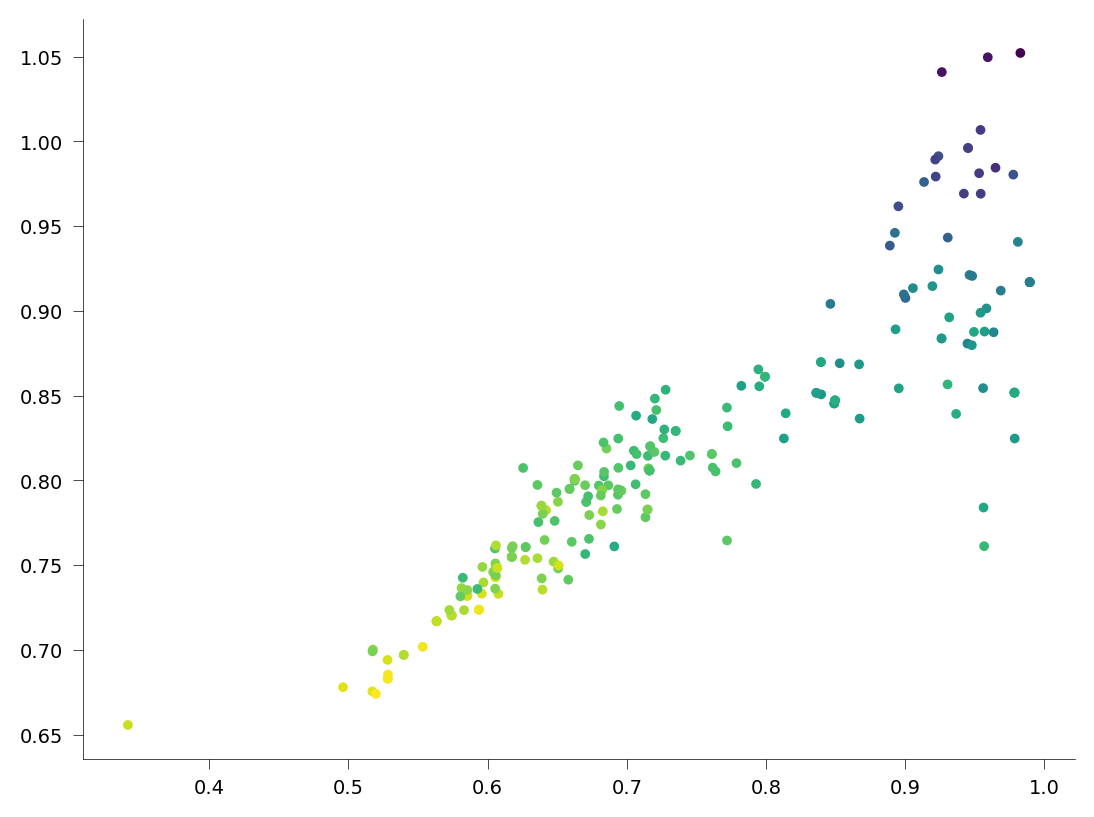

In [220]:
plt.scatter(ds_use.lapse_lcl/ds_use.PREFHT, ds_use.p_lcl5/ds_use.PREFHT, c=ds_use.TREFHT)